# Space Y Falcon 9 First Stage Landing Prediction

![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/landing_1.gif)

In [90]:
import requests
import pandas as pd
import numpy as np
import datetime
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

## Data mining

In [91]:
# Request and parse the launch data
spacex_url="https://api.spacexdata.com/v4/launches/past"
response = requests.get(spacex_url)
spacex_data = response.json()
data = pd.json_normalize(spacex_data)

In [92]:
# keeping only the features we want and the flight number, and date_utc
data = data[['rocket', 'payloads', 'launchpad', 'cores', 'flight_number', 'date_utc']]

# We will remove rows with multiple cores because those are falcon rockets with 2 extra rocket boosters and rows that have multiple payloads in a single rocket.
data = data[data['cores'].map(len)==1]
data = data[data['payloads'].map(len)==1]
data['cores'] = data['cores'].map(lambda x : x[0])
data['payloads'] = data['payloads'].map(lambda x : x[0])

# We also want to convert the date_utc to a datetime datatype and then extracting the date leaving the time
data['date'] = pd.to_datetime(data['date_utc']).dt.date
data = data[data['date'] <= datetime.date(2020, 11, 13)]

In [93]:
#Global variables 
BoosterVersion = []
PayloadMass = []
Orbit = []
LaunchSite = []
Outcome = []
Flights = []
GridFins = []
Reused = []
Legs = []
LandingPad = []
Block = []
ReusedCount = []
Serial = []
Longitude = []
Latitude = []

#### Takes the dataset and uses columns to call the API and append the data to the list

In [94]:
for x in data['rocket']:
    if x:
        response = requests.get("https://api.spacexdata.com/v4/rockets/"+str(x)).json()
        BoosterVersion.append(response['name'])

In [95]:
for x in data['launchpad']:
    if x:
        response = requests.get("https://api.spacexdata.com/v4/launchpads/"+str(x)).json()
        Longitude.append(response['longitude'])
        Latitude.append(response['latitude'])
        LaunchSite.append(response['name'])

In [96]:
for load in data['payloads']:
    if load:
        response = requests.get("https://api.spacexdata.com/v4/payloads/"+load).json()
        PayloadMass.append(response['mass_kg'])
        Orbit.append(response['orbit'])

In [97]:
for core in data['cores']:
    if core['core'] != None:
        response = requests.get("https://api.spacexdata.com/v4/cores/"+core['core']).json()
        Block.append(response['block'])
        ReusedCount.append(response['reuse_count'])
        Serial.append(response['serial'])
    else:
        Block.append(None)
        ReusedCount.append(None)
        Serial.append(None)
    Outcome.append(str(core['landing_success'])+' '+str(core['landing_type']))
    Flights.append(core['flight'])
    GridFins.append(core['gridfins'])
    Reused.append(core['reused'])
    Legs.append(core['legs'])
    LandingPad.append(core['landpad'])

#### Constructing our dataset using the data we have obtained. We we combine the columns into a dictionary

In [98]:
launch_dict = {'FlightNumber': list(data['flight_number']),
'Date': list(data['date']),
'BoosterVersion':BoosterVersion,
'PayloadMass':PayloadMass,
'Orbit':Orbit,
'LaunchSite':LaunchSite,
'Outcome':Outcome,
'Flights':Flights,
'GridFins':GridFins,
'Reused':Reused,
'Legs':Legs,
'LandingPad':LandingPad,
'Block':Block,
'ReusedCount':ReusedCount,
'Serial':Serial,
'Longitude': Longitude,
'Latitude': Latitude}

In [99]:
# Create a data from launch_dict
df = pd.DataFrame(launch_dict)

## Data cleaning

In [100]:
# Remove the Falcon 1 launches keeping only the Falcon 9 launches
data_falcon9 = df[df['BoosterVersion'] == 'Falcon 9'].copy()
data_falcon9['FlightNumber'] = range(1, data_falcon9.shape[0] + 1)
data_falcon9.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
4,1,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857
5,2,2012-05-22,Falcon 9,525.0,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857
6,3,2013-03-01,Falcon 9,677.0,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857
7,4,2013-09-29,Falcon 9,500.0,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093
8,5,2013-12-03,Falcon 9,3170.0,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857


In [101]:
data_falcon9.isnull().sum()

FlightNumber       0
Date               0
BoosterVersion     0
PayloadMass        5
Orbit              0
LaunchSite         0
Outcome            0
Flights            0
GridFins           0
Reused             0
Legs               0
LandingPad        26
Block              0
ReusedCount        0
Serial             0
Longitude          0
Latitude           0
dtype: int64

In [102]:
# Calculate the mean value of PayloadMass column
payload_mass_mean = data_falcon9['PayloadMass'].mean()

# Replace the np.nan values with its mean value
data_falcon9['PayloadMass'] = data_falcon9['PayloadMass'].replace(np.NaN, payload_mass_mean)

In [103]:
# Identify and calculate the percentage of the missing values in each attribute
data_falcon9.isnull().sum()/data_falcon9.shape[0]*100

FlightNumber       0.000000
Date               0.000000
BoosterVersion     0.000000
PayloadMass        0.000000
Orbit              0.000000
LaunchSite         0.000000
Outcome            0.000000
Flights            0.000000
GridFins           0.000000
Reused             0.000000
Legs               0.000000
LandingPad        28.888889
Block              0.000000
ReusedCount        0.000000
Serial             0.000000
Longitude          0.000000
Latitude           0.000000
dtype: float64

In [104]:
data_falcon9.dtypes

FlightNumber        int64
Date               object
BoosterVersion     object
PayloadMass       float64
Orbit              object
LaunchSite         object
Outcome            object
Flights             int64
GridFins             bool
Reused               bool
Legs                 bool
LandingPad         object
Block             float64
ReusedCount         int64
Serial             object
Longitude         float64
Latitude          float64
dtype: object

## Exploratory data analysis

![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/crash.gif)
​

#### Calculate the number of launches on each site

In [105]:
data_falcon9['LaunchSite'].value_counts()

CCSFS SLC 40    55
KSC LC 39A      22
VAFB SLC 4E     13
Name: LaunchSite, dtype: int64

#### Calculate the number and occurrence of each orbit

In [106]:
data_falcon9['Orbit'].value_counts()

GTO      27
ISS      21
VLEO     14
PO        9
LEO       7
SSO       5
MEO       3
ES-L1     1
HEO       1
SO        1
GEO       1
Name: Orbit, dtype: int64

#### Calculate the number and occurence of mission outcome per orbit type

In [107]:
# landing_outcomes = values on Outcome column
landing_outcomes = data_falcon9['Outcome'].value_counts()
landing_outcomes

True ASDS      41
None None      19
True RTLS      14
False ASDS      6
True Ocean      5
False Ocean     2
None ASDS       2
False RTLS      1
Name: Outcome, dtype: int64

In [108]:
for i,outcome in enumerate(landing_outcomes.keys()):
    print(i,outcome)

0 True ASDS
1 None None
2 True RTLS
3 False ASDS
4 True Ocean
5 False Ocean
6 None ASDS
7 False RTLS


In [109]:
# We create a set of outcomes where the second stage did not land successfully
bad_outcomes=set(landing_outcomes.keys()[[1,3,5,6,7]])
bad_outcomes

{'False ASDS', 'False Ocean', 'False RTLS', 'None ASDS', 'None None'}

#### Create a landing outcome label from Outcome column

In [110]:
# landing_class = 0 if bad_outcome
# landing_class = 1 otherwise
landing_class = []
for i in data_falcon9['Outcome']:
    if i in bad_outcomes:
        landing_class.append('0')
    else:
        landing_class.append('1')

In [111]:
data_falcon9['Class']=landing_class
data_falcon9[['Class']].head(8)

,Class
4,0
5,0
6,0
7,0
8,0
9,0
10,1
11,1


In [112]:
data_falcon9["Class"].mean()

1.2222233334445679e+81

## Connect to the database

#### Load the SQL extension and establish a connection with the database

In [113]:
%load_ext sql

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [114]:
con = sqlite3.connect("my_data1.db")
cur = con.cursor()

In [115]:
%sql sqlite:///my_data1.db

In [116]:
data_falcon9.to_sql("SPACEXTBL", con, if_exists='replace', index=False,method="multi")

90

In [117]:
%sql create table SPACEXTABLE as select * from SPACEXTBL where Date is not null

 * sqlite:///my_data1.db
(sqlite3.OperationalError) table SPACEXTABLE already exists
[SQL: create table SPACEXTABLE as select * from SPACEXTBL where Date is not null]
(Background on this error at: https://sqlalche.me/e/20/e3q8)


In [118]:
%%sql 
SELECT *
FROM SPACEXTBL
LIMIT 5

 * sqlite:///my_data1.db
Done.


FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
1,2010-06-04,Falcon 9,6123.547647058824,LEO,CCSFS SLC 40,None None,1,0,0,0,None,1.0,0,B0003,-80.577366,28.5618571,0
2,2012-05-22,Falcon 9,525.0,LEO,CCSFS SLC 40,None None,1,0,0,0,None,1.0,0,B0005,-80.577366,28.5618571,0
3,2013-03-01,Falcon 9,677.0,ISS,CCSFS SLC 40,None None,1,0,0,0,None,1.0,0,B0007,-80.577366,28.5618571,0
4,2013-09-29,Falcon 9,500.0,PO,VAFB SLC 4E,False Ocean,1,0,0,0,None,1.0,0,B1003,-120.610829,34.632093,0
5,2013-12-03,Falcon 9,3170.0,GTO,CCSFS SLC 40,None None,1,0,0,0,None,1.0,0,B1004,-80.577366,28.5618571,0


In [119]:
# Display the names of the unique launch sites in the space mission
%sql SELECT DISTINCT LaunchSite FROM SPACEXTBL

 * sqlite:///my_data1.db
Done.


LaunchSite
CCSFS SLC 40
VAFB SLC 4E
KSC LC 39A


In [120]:
# Display the total payload mass carried by boosters launched by Falcon 9
%sql SELECT AVG(PayloadMass	) FROM SPACEXTBL WHERE BoosterVersion=='Falcon 9'

 * sqlite:///my_data1.db
Done.


AVG(PayloadMass )
6123.547647058824


In [121]:
%sql SELECT DISTINCT(Outcome) FROM SPACEXTBL

 * sqlite:///my_data1.db
Done.


Outcome
None None
False Ocean
True Ocean
False ASDS
None ASDS
True RTLS
True ASDS
False RTLS


In [122]:
# List the date when the first succesful landing outcome was acheived.
%sql SELECT MIN(Date) FROM SPACEXTBL WHERE Outcome like '%True%'

 * sqlite:///my_data1.db
Done.


MIN(Date)
2014-04-18


In [123]:
# List the names of the boosters which have success in drone ship and have payload mass greater than 4000 but less than 6000
%sql SELECT * FROM SPACEXTBL WHERE Outcome LIKE '%True%' AND PayloadMass BETWEEN 4000 AND 6000

 * sqlite:///my_data1.db
Done.


FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
21,2016-05-06,Falcon 9,4696.0,GTO,CCSFS SLC 40,True ASDS,1,1,0,1,5e9e3032383ecb6bb234e7ca,2.0,0,B1022,-80.577366,28.5618571,1
24,2016-08-14,Falcon 9,4600.0,GTO,CCSFS SLC 40,True ASDS,1,1,0,1,5e9e3032383ecb6bb234e7ca,2.0,0,B1026,-80.577366,28.5618571,1
29,2017-03-30,Falcon 9,5300.0,GTO,KSC LC 39A,True ASDS,2,1,1,1,5e9e3032383ecb6bb234e7ca,2.0,1,B1021,-80.6039558,28.6080585,1
38,2017-09-07,Falcon 9,4990.0,LEO,KSC LC 39A,True RTLS,1,1,0,1,5e9e3032383ecb267a34e7c7,4.0,1,B1040,-80.6039558,28.6080585,1
40,2017-10-11,Falcon 9,5200.0,GTO,KSC LC 39A,True ASDS,2,1,1,1,5e9e3032383ecb6bb234e7ca,3.0,1,B1031,-80.6039558,28.6080585,1
45,2018-01-31,Falcon 9,4230.0,GTO,CCSFS SLC 40,True Ocean,2,1,1,1,None,3.0,1,B1032,-80.577366,28.5618571,1
55,2018-08-07,Falcon 9,5800.0,GTO,CCSFS SLC 40,True ASDS,2,1,1,1,5e9e3032383ecb6bb234e7ca,5.0,3,B1046,-80.577366,28.5618571,1
59,2018-12-03,Falcon 9,4000.0,SSO,VAFB SLC 4E,True ASDS,3,1,1,1,5e9e3033383ecbb9e534e7cc,5.0,3,B1046,-120.610829,34.632093,1
70,2019-12-05,Falcon 9,5000.0,ISS,CCSFS SLC 40,True ASDS,1,1,0,1,5e9e3032383ecb6bb234e7ca,5.0,5,B1059,-80.577366,28.5618571,1


In [124]:
# List the total number of successful mission outcomes
%sql SELECT COUNT(Outcome) FROM SPACEXTBL WHERE Outcome LIKE '%True%'

 * sqlite:///my_data1.db
Done.


COUNT(Outcome)
60


## Data Visualization

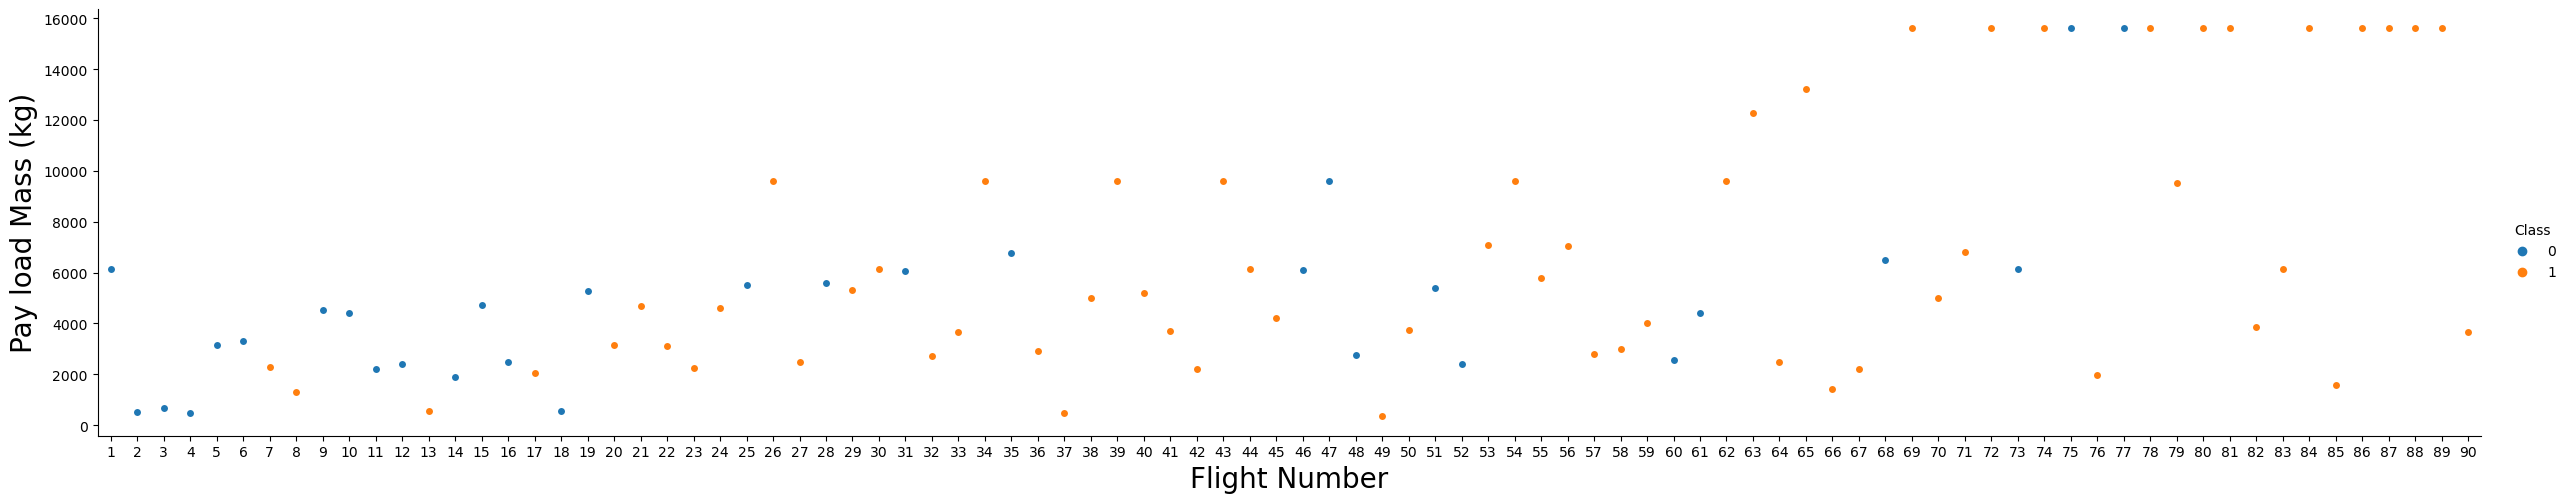

In [125]:
# FlightNumber vs. PayloadMass overlay
sns.catplot(y="PayloadMass", x="FlightNumber", hue="Class", data=data_falcon9, aspect = 5)
plt.xlabel("Flight Number",fontsize=20)
plt.ylabel("Pay load Mass (kg)",fontsize=20)
plt.show()

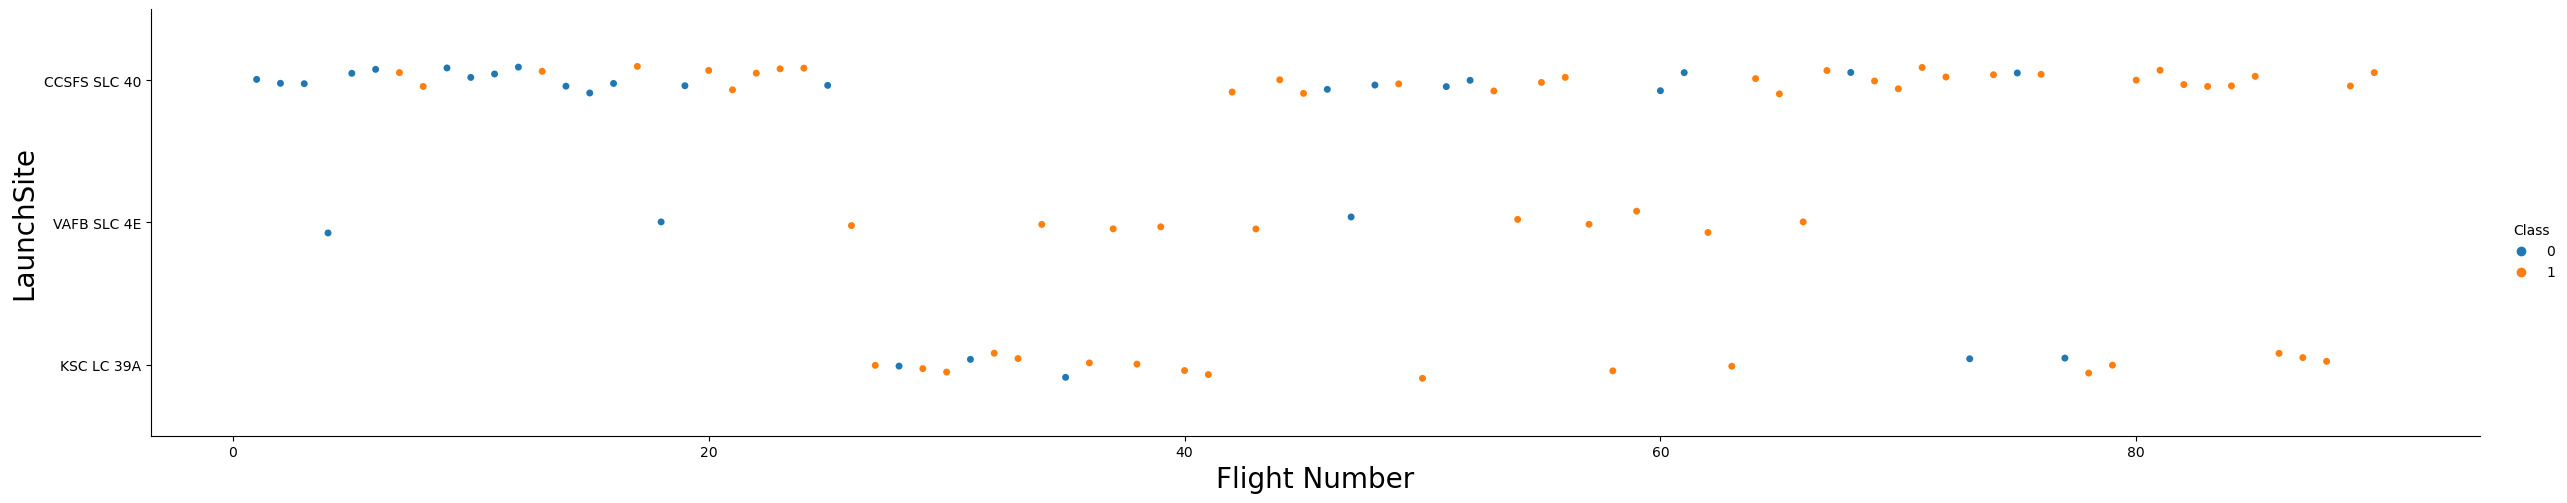

In [126]:
# Detailed launch records of each site
sns.catplot(y="LaunchSite", x="FlightNumber", hue="Class", data=data_falcon9, aspect = 5)
plt.xlabel("Flight Number",fontsize=20)
plt.ylabel("LaunchSite",fontsize=20)
plt.show()

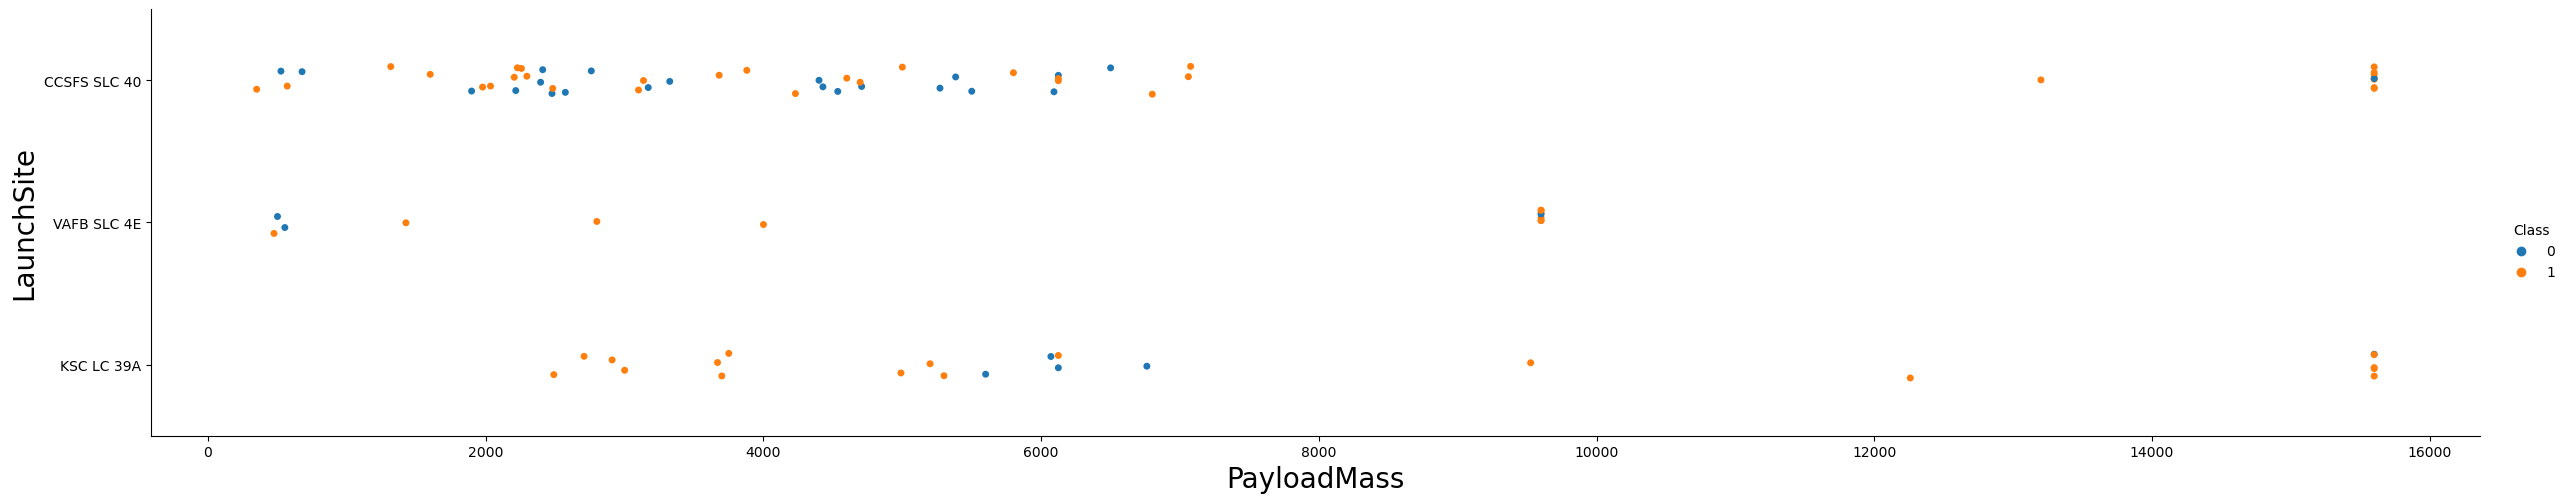

In [127]:
# The relationship between Payload and Launch Site
sns.catplot(y="LaunchSite", x="PayloadMass", hue="Class", data=data_falcon9, aspect = 5)
plt.xlabel("PayloadMass",fontsize=20)
plt.ylabel("LaunchSite",fontsize=20)
plt.show()

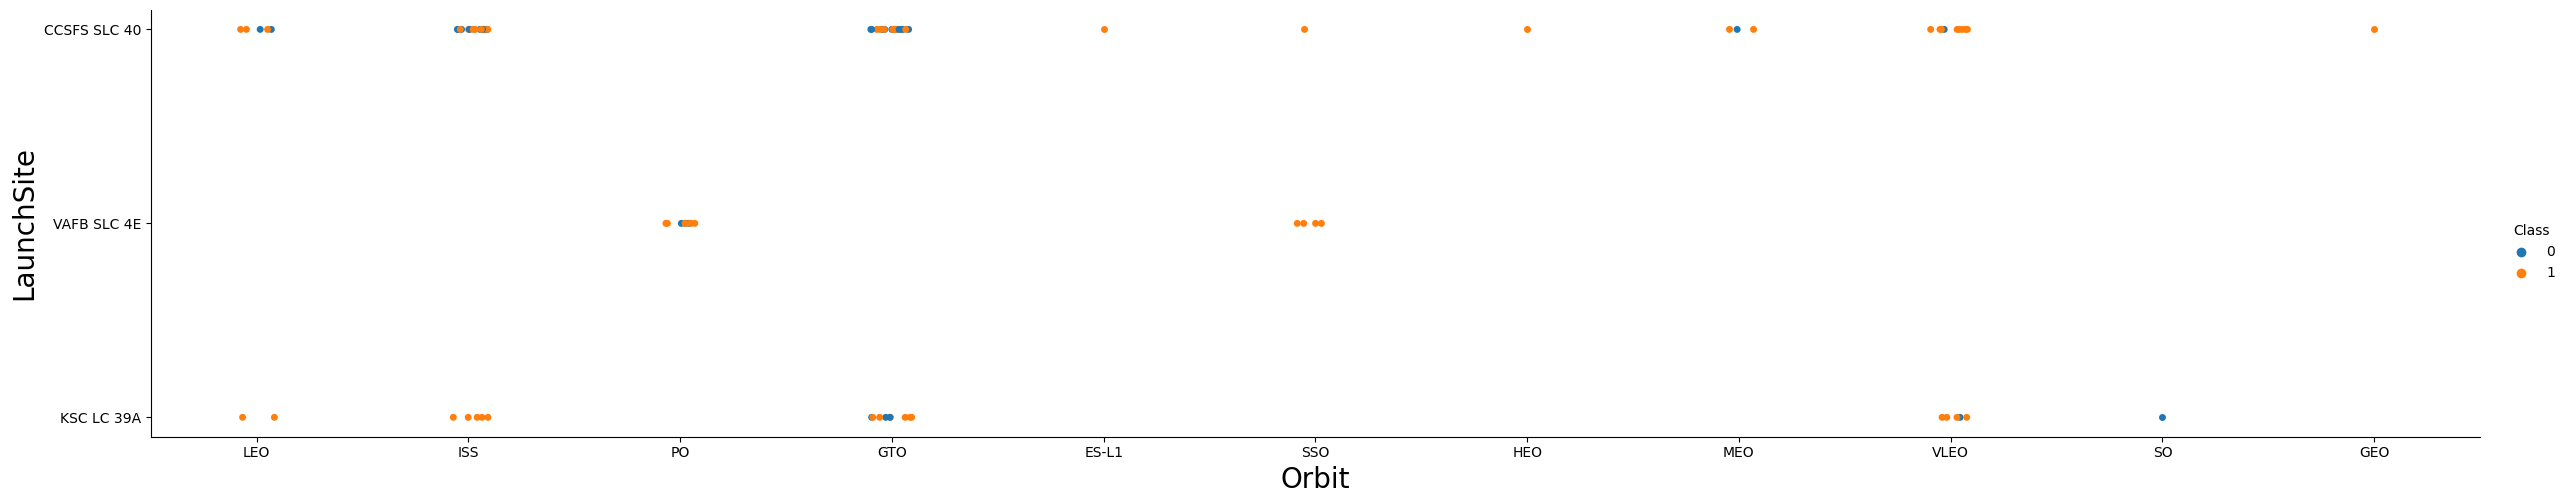

In [128]:
# The relationship between success rate of each orbit type
sns.catplot(y="LaunchSite", x="Orbit", hue="Class", data=data_falcon9, aspect = 5)
plt.xlabel("Orbit",fontsize=20)
plt.ylabel("LaunchSite",fontsize=20)
plt.show()

In [169]:
mean_class_by_orbit = data_falcon9.groupby('Orbit')['Class'].mean().reset_index()
data_falcon9['Class'] = data_falcon9['Class'].astype(float)
mean_class_by_orbit

,Orbit,Class
0,ES-L1,1.000000
1,GEO,1.000000
2,GTO,0.518519
3,HEO,1.000000
4,ISS,0.619048
5,LEO,0.714286
6,MEO,0.666667
7,PO,0.666667
8,SO,0.000000
9,SSO,1.000000


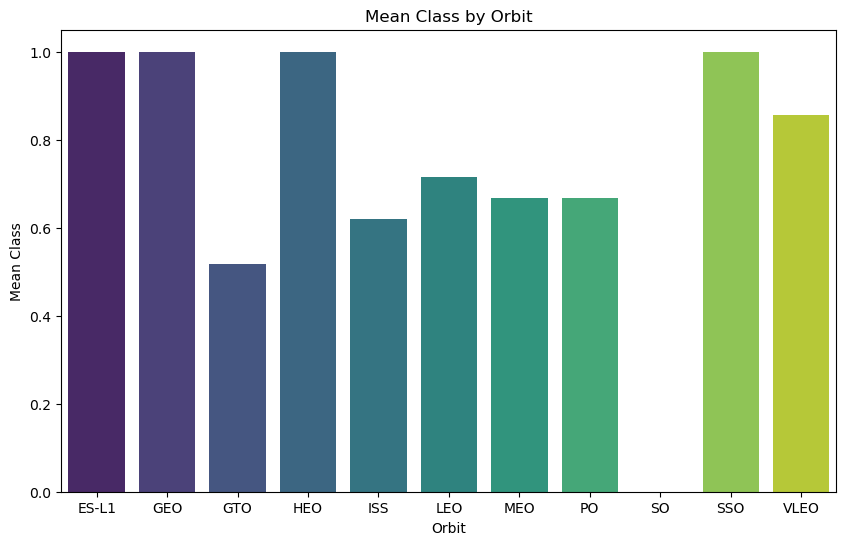

In [170]:
# Bar chart for the sucess rate of each orbit
plt.figure(figsize=(10, 6))
sns.barplot(x='Orbit', y='Class', data=mean_class_by_orbit, palette='viridis')

plt.xlabel('Orbit')
plt.ylabel('Mean Class')
plt.title('Mean Class by Orbit')

plt.show()

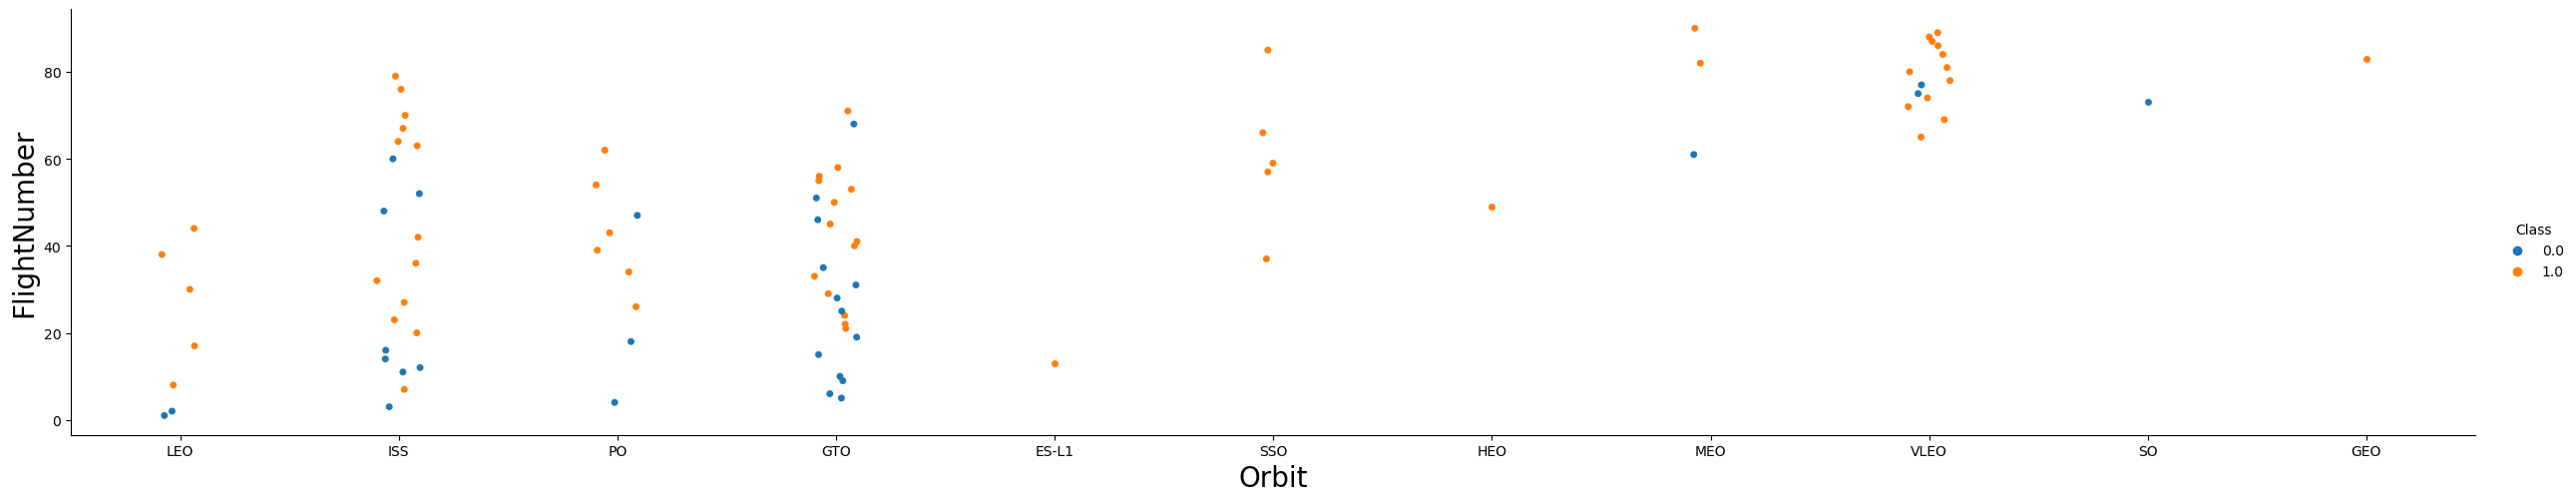

In [168]:
# The relationship between FlightNumber and Orbit type
sns.catplot(y="FlightNumber", x="Orbit", hue="Class", data=data_falcon9, aspect = 5)
plt.xlabel("Orbit",fontsize=20)
plt.ylabel("FlightNumber",fontsize=20)
plt.show()

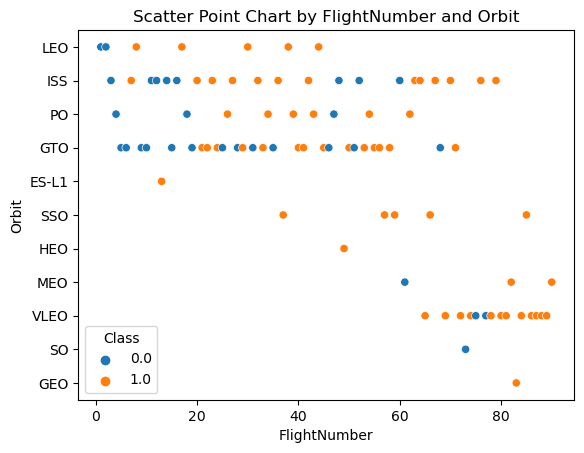

In [132]:
# For each orbit, we want to see if there is any relationship between FlightNumber and Orbit type.
sns.scatterplot(x='FlightNumber', y='Orbit', hue='Class', data=data_falcon9)

plt.xlabel('FlightNumber')
plt.ylabel('Orbit')
plt.title('Scatter Point Chart by FlightNumber and Orbit')

plt.legend(title='Class')

plt.show()

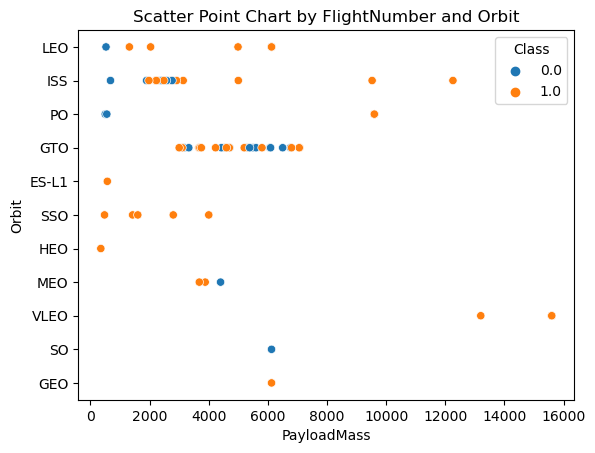

In [133]:
# The relationship between Payload and Orbit type
sns.scatterplot(x='PayloadMass', y='Orbit', hue='Class', data=data_falcon9)

plt.xlabel('PayloadMass')
plt.ylabel('Orbit')
plt.title('Scatter Point Chart by FlightNumber and Orbit')

plt.legend(title='Class')

plt.show()

In [134]:
# Extracting year from Data
year = []

def extract_year():
    for date in data_falcon9["Date"]:
        year.append(str(date).split("-")[0])
    return year

extract_year()
data_falcon9['Date'] = year
data_falcon9.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
4,1,2010,Falcon 9,6123.547647,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857,0.0
5,2,2012,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857,0.0
6,3,2013,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857,0.0
7,4,2013,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093,0.0
8,5,2013,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857,0.0


In [135]:
# The launch success yearly trend
average_success_by_year = data_falcon9.groupby('Date')['Class'].mean().reset_index()
data_falcon9['Class'] = data_falcon9['Class'].astype(float)
average_success_by_year

,Date,Class
0,2010,0.000000
1,2012,0.000000
2,2013,0.000000
3,2014,0.333333
4,2015,0.333333
5,2016,0.625000
6,2017,0.833333
7,2018,0.611111
8,2019,0.900000
9,2020,0.842105


#### Observe that the sucess rate since 2013 kept increasing till 2020

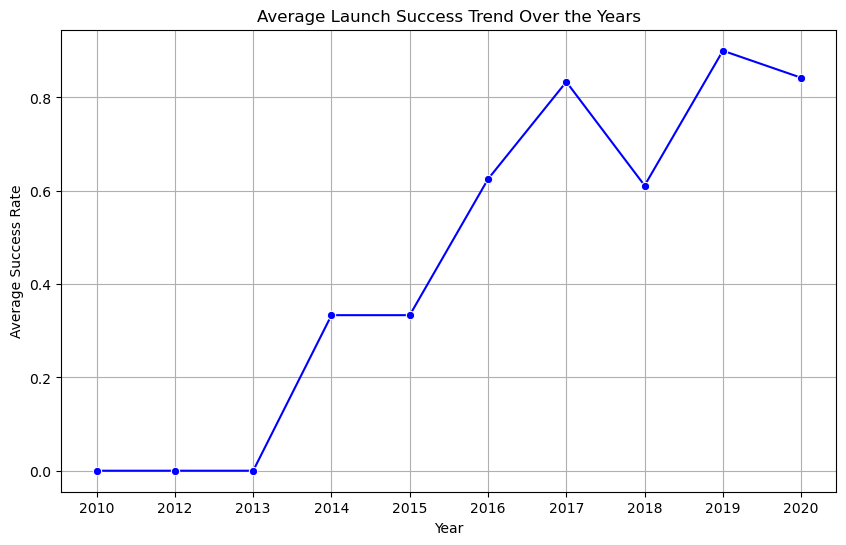

In [136]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='Date', y='Class', data=average_success_by_year, marker='o', color='blue')

plt.xlabel('Year')
plt.ylabel('Average Success Rate')
plt.title('Average Launch Success Trend Over the Years')

plt.grid(True)
plt.show()

## Machine Learning

In [137]:
features = data_falcon9[['FlightNumber', 'PayloadMass', 'Orbit', 'LaunchSite', 'Flights', 'GridFins', 'Reused', 'Legs', 'LandingPad', 'Block', 'ReusedCount', 'Serial']]
features.head()

,FlightNumber,PayloadMass,Orbit,LaunchSite,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial
4,1,6123.547647,LEO,CCSFS SLC 40,1,False,False,False,None,1.0,0,B0003
5,2,525.000000,LEO,CCSFS SLC 40,1,False,False,False,None,1.0,0,B0005
6,3,677.000000,ISS,CCSFS SLC 40,1,False,False,False,None,1.0,0,B0007
7,4,500.000000,PO,VAFB SLC 4E,1,False,False,False,None,1.0,0,B1003
8,5,3170.000000,GTO,CCSFS SLC 40,1,False,False,False,None,1.0,0,B1004


In [138]:
# Create dummy variables to categorical columns
features = pd.get_dummies(features, columns=['Orbit', 'LaunchSite', 'LandingPad', 'Serial'])
features

,FlightNumber,PayloadMass,Flights,GridFins,Reused,Legs,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,...,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062
4,1,6123.547647,1,False,False,False,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2,525.000000,1,False,False,False,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,3,677.000000,1,False,False,False,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,4,500.000000,1,False,False,False,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,5,3170.000000,1,False,False,False,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,86,15600.000000,2,True,True,True,5.0,12,0,0,...,0,0,0,0,0,0,0,0,1,0
90,87,15600.000000,3,True,True,True,5.0,13,0,0,...,0,0,0,0,0,0,1,0,0,0
91,88,15600.000000,6,True,True,True,5.0,12,0,0,...,0,0,0,1,0,0,0,0,0,0
92,89,15600.000000,3,True,True,True,5.0,12,0,0,...,0,0,0,0,0,0,0,0,1,0


In [139]:
# Cast all numeric columns to `float64`
numeric_columns = features.select_dtypes(include=['number'])

features[numeric_columns.columns] = features[numeric_columns.columns].astype('float64')
features.dtypes

FlightNumber    float64
PayloadMass     float64
Flights         float64
GridFins           bool
Reused             bool
                 ...   
Serial_B1056    float64
Serial_B1058    float64
Serial_B1059    float64
Serial_B1060    float64
Serial_B1062    float64
Length: 80, dtype: object

In [140]:
# Function for confusion matrix

def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed']) 
    plt.show() 

In [141]:
# Create a NumPy array from the column Class
Y = data_falcon9['Class'].to_numpy()
Y

array([0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0.,
       0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.])

In [142]:
# Standardize the data in X
transform = preprocessing.StandardScaler()
X = transform.fit_transform(numeric_columns)
X

array([[-1.71291154,  0.        , -0.65391284, ..., -0.21566555,
        -0.18569534, -0.10599979],
       [-1.67441914, -1.18972425, -0.65391284, ..., -0.21566555,
        -0.18569534, -0.10599979],
       [-1.63592675, -1.15742336, -0.65391284, ..., -0.21566555,
        -0.18569534, -0.10599979],
       ...,
       [ 1.63592675,  2.01380177,  3.49060516, ..., -0.21566555,
        -0.18569534, -0.10599979],
       [ 1.67441914,  2.01380177,  1.00389436, ..., -0.21566555,
         5.38516481, -0.10599979],
       [ 1.71291154, -0.51905572, -0.65391284, ..., -0.21566555,
        -0.18569534,  9.43398113]])

In [143]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

In [144]:
Y_test.shape

(18,)

#### Create a logistic regression object

In [145]:
parameters ={'C':[0.01,0.1,1],
             'penalty':['l2'],
             'solver':['lbfgs']}

In [146]:
parameters ={"C":[0.01,0.1,1],'penalty':['l2'], 'solver':['lbfgs']}# l1 lasso l2 ridge
lr=LogisticRegression()
lr

logreg_cv = GridSearchCV(lr, parameters, cv=10)

# Fit the GridSearchCV object to find the best parameters
logreg_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                         'solver': ['lbfgs']})

In [147]:
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.7107142857142857


#### Calculate the accuracy on the test data

In [148]:
accuracy = logreg_cv.score(X_test, Y_test)
accuracy

0.7777777777777778

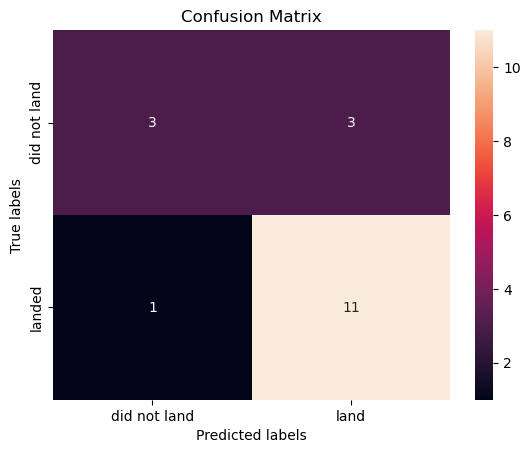

In [149]:
# Lets look at the confusion matrix
yhat=logreg_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

#### Create a support vector machine object

In [150]:
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
svm = SVC()

In [151]:
svm_cv = GridSearchCV(svm, parameters, cv=10)

In [152]:
svm_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'gamma': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'kernel': ('linear', 'rbf', 'poly', 'rbf', 'sigmoid')})

In [153]:
print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)
print("accuracy :",svm_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 31.622776601683793, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}
accuracy : 0.8071428571428572


#### Calculate the accuracy on the test data

In [154]:
svm_cv.score(X_train, Y_train)

0.9444444444444444

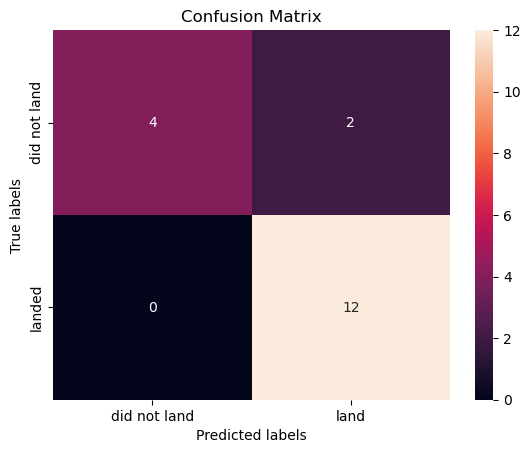

In [155]:
yhat=svm_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

#### Create a decision tree classifier object

In [156]:
parameters = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [2 * n for n in range(1, 10)],
    'max_features': ['sqrt'],  # Set 'max_features' explicitly to 'sqrt'
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10]
}

tree = DecisionTreeClassifier()

In [157]:
tree_cv = GridSearchCV(tree, parameters, cv=10)

# Fit the GridSearchCV object to find the best parameters
tree_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']})

In [158]:
print("tuned hpyerparameters :(best parameters) ",tree_cv.best_params_)
print("accuracy :",tree_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'criterion': 'entropy', 'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}
accuracy : 0.7928571428571428


#### Calculate the accuracy of tree_cv on the test data

In [159]:
tree_cv.score(X_test, Y_test)

0.6111111111111112

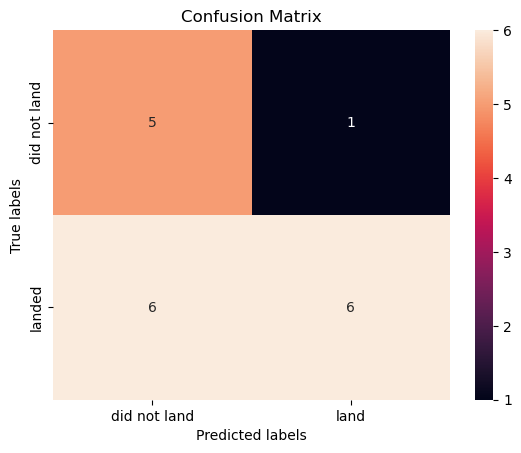

In [160]:
yhat = tree_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

#### Create a k nearest neighbors object

In [161]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN = KNeighborsClassifier()

In [162]:
knn_cv = GridSearchCV(KNN, parameters, cv=10)
knn_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'p': [1, 2]})

In [163]:
print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 3, 'p': 1}
accuracy : 0.7124999999999999


#### Calculate the accuracy of knn_cv on the test data 

In [164]:
knn_cv.score(X_test, Y_test)

0.7777777777777778

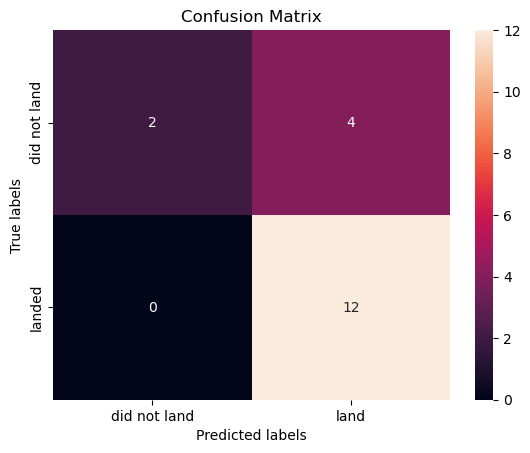

In [165]:
yhat = knn_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

#### Find the method performs best

In [166]:
logreg_accuracy = logreg_cv.score(X_test, Y_test)
svm_accuracy = svm_cv.score(X_test, Y_test)
tree_accuracy = tree_cv.score(X_test, Y_test)
knn_accuracy = knn_cv.score(X_test, Y_test)

# Create a dictionary to store the accuracies
accuracies = {
    'Logistic Regression': logreg_accuracy,
    'Support Vector Machine': svm_accuracy,
    'Decision Tree': tree_accuracy,
    'K-Nearest Neighbors': knn_accuracy
}

# Find the method with the highest accuracy
best_method = max(accuracies, key=accuracies.get)
best_accuracy = accuracies[best_method]

# Print the results
print("Accuracy on Test Data:")
for method, accuracy in accuracies.items():
    print(f"{method}: {accuracy:.4f}")

print(f"\nThe method that performs best is {best_method} with an accuracy of {best_accuracy:.4f}")

Accuracy on Test Data:
Logistic Regression: 0.7778
Support Vector Machine: 0.8889
Decision Tree: 0.6111
K-Nearest Neighbors: 0.7778

The method that performs best is Support Vector Machine with an accuracy of 0.8889
